# Trajectory Construction 

This note describes how we construct trajectories from photos/movies of [YFCC100M dataset](http://arxiv.org/abs/1502.03409).

**Three major steps for constructing trajectories:**

1. Extract photos/videos taken near Melbourne area from original YFCC100M dataset (`filtering_bigbox.py`)
2. Extract initial trajectories based on the extracted photos/videos (`generate_tables.py`)
3. Filter out some abnormal trajectories using various criteria (in this notebook)


## Construction Process
* [1. Extract initial relevant points from YFCC100M dataset](#1.-Extracting-relevant-points-from-YFCC100M-dataset)
    * [1.1. Basic stats of initial dataset](#1.1.-Basic-stats-of-initial-dataset)
    * [1.2. Scatter plot of extracted points](#1.2.-Scatter-plot-of-extracted-points)
* [2. Extract initial trajectories from extracted points](#2.-Extract-initial-trajectories-from-extracted-points)
    * [2.1 Basic stats after extracting initial trajectories](#2.1-Basic-stats-after-extracting-initial-trajectories)
* [3. Filter Trajectory](#3.-Filter-Trajectory)
    * [3.1. Filter by Timeframe](#3.1.-Filter-by-Timeframe)
        * [3.1.1. Bar chart of taken photos by year](#3.1.1.-Bar-chart-of-taken-photos-by-year)
    * [3.2. Filter by Duration](#3.2.-Filter-by-Duration)
        * [3.2.1. Histogram of trajectory duration](#3.2.1.-Histogram-of-trajectory-duration)
    * [3.3. Filter by Minimum distance](#3.3.-Filter-by-Minimum-distance)
        * [3.3.1. Histogram of trajectory length](#3.3.1.-Histogram-of-trajectory-length)
    * [3.4. Filter by Speed](#3.4.-Filter-by-Speed)
        * [3.4.1. Drop trajectory by average speed](#3.4.1.-Drop-trajectory-by-averag--speed)
            * [3.4.1.1. Histogram of trajectory speed](#3.4.1.1.-Histogram-of-trajectory-speed)
        * [3.4.2. Drop trajectory by point-to-point speed](#3.4.2.-Drop-trajectory-by-point-to-point-speed)
            * [3.4.2.1. Histogram of point-to-point speed](#3.4.2.1.-Histogram-of-point-to-point-speed)
        * [3.4.3. Drop trajectory by sophisticated method](#3.4.3-Drop-trajectory-by-sophisticated-method)
* [4. Filtered Trajectory](#4.-Filtered-Trajectory)
    * [4.1. Basic Stats](#4.1.-Basic-Stats)

# 1. Extract relevant points from YFCC100M dataset

From the original YFCC100M dataset, we first extract the photos/movies belongs to the below region.

![big-box](./img/bigbox.png)

`filtering_bigbox.py` file take the original YFCC100M file to extract photos and videos from above region, and will generate a cvs file containing:
* Photo/video ID
* NSID (user ID)
* Date
* Longitude
* Latitude
* Accuracy (GPS accuracy)
* Photo/video URL
* Photo/video identifier (0 = photo, 1 = video)

The usage of this file is :
> `python filtering_bigbox.py YFCC100M_DATA_FILE`

which will generate `out.YFCC100M_DATA_FILE` file

In [1]:
%matplotlib inline

import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import generate_tables
import traj_visualise

data_dir = '../data/'
raw_table = os.path.join(data_dir, 'Melb-bigbox.csv')
raw = pd.read_csv(raw_table, parse_dates=[2], skipinitialspace=True)

## 1.1. Basic stats of initial dataset


In [2]:
print('Number of photos:', raw['Photo_ID'].shape[0])
print('Number of users: ', raw['User_ID'].unique().shape[0])
raw[['Longitude', 'Latitude', 'Accuracy']].describe() 
# Longitude should be in [141.9, 147.1]
# Latitude should be in [-39.3, -35.8]
# Accuracy should be in [1, 16]

Number of photos: 216472
Number of users:  2982


,Longitude,Latitude,Accuracy
count,216472.000000,216472.000000,216472.00000
mean,144.896785,-37.834228,14.27356
std,0.652072,0.408834,2.09961
min,141.902733,-39.284489,1.00000
25%,144.937386,-37.878579,13.00000
50%,144.967147,-37.818361,15.00000
75%,145.021247,-37.797848,16.00000
max,147.098680,-35.804727,16.00000


### 1.2. Scatter plot of extracted points

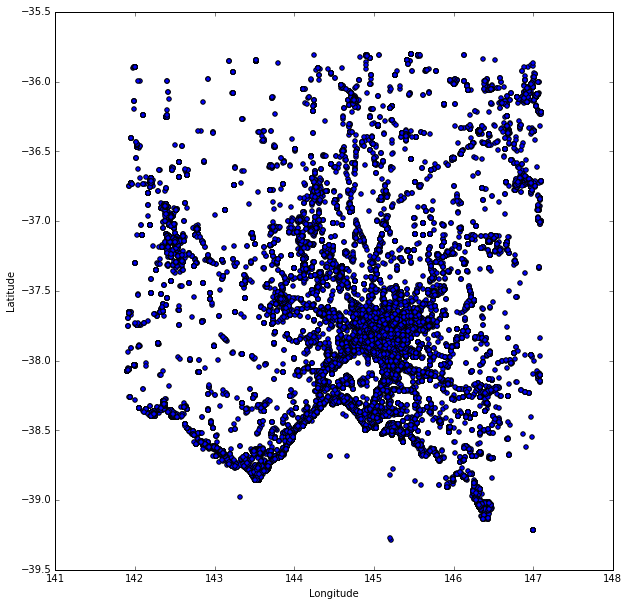

In [3]:
plt.figure(figsize=[10, 10])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(raw['Longitude'], raw['Latitude'])

# 2. Extract initial trajectories from extracted points

With extracted photos(videos) by `filtering_bigbox.py`, we construct initial trajectories with following processes based on several basic criteria.

1. Group photos by user
2. Sort grouped photos by timestamp
3. Split the sorted photos where the second photo of two adjacent photos are taken more than `time_gap` time after
4. Keep trajectories of which at **least one photo** is taken from the below region:

![small-box](./img/smallbox.png)

Here's the argument list:

In [4]:
extracted_points_file = os.path.join(data_dir, 'Melb-bigbox.csv') # outputfile path of extracted points
time_gap = 8  # hour
minimum_photo = 1 # minimum number of photos for each trajectory

# small bounding box
lng_min = 144.597363
lat_min = -38.072257
lng_max = 145.360413
lat_max = -37.591764

`generate_tables.py` will generate the inital trajectories using above arguments.

In [5]:
%run generate_tables $extracted_points_file $lng_min $lat_min $lng_max $lat_max $minimum_photo $time_gap 

In [6]:
table1 = 'Melb-table1.csv'
table2 = 'Melb-table2.csv'
photo_table = os.path.join(data_dir, table1)
traj_table = os.path.join(data_dir, table2)
traj = pd.read_csv(photo_table, parse_dates=[3], skipinitialspace=True)
traj_stats = pd.read_csv(traj_table, parse_dates=[3], skipinitialspace=True)

## 2.1. Basic stats after extracting initial trajectories

In [7]:
print('Number of photos:', traj['Photo_ID'].shape[0])
print('Number of users: ', traj_stats['User_ID'].unique().shape[0])
print('Number of trajectories:', traj_stats['Trajectory_ID'].shape[0])
print('Average number of photos per user:', \
      1.0 * traj['Photo_ID'].shape[0] / traj_stats['User_ID'].unique().shape[0])
print('Average number of trajectories per user:', \
      1.0 * traj_stats['Trajectory_ID'].shape[0] / traj_stats['User_ID'].unique().shape[0])

Number of photos: 151585
Number of users:  2443
Number of trajectories: 26468
Average number of photos per user: 62.0487106017192
Average number of trajectories per user: 10.834220221039706


In [8]:
traj_stats[['#Photo', 'Travel_Distance(km)', 'Total_Time(min)', 'Average_Speed(km/h)']].describe()

,#Photo,Travel_Distance(km),Total_Time(min),Average_Speed(km/h)
count,26468.000000,26468.000000,26468.000000,26468.000000
mean,5.727104,6.428739,69.438155,203.032228
std,18.028451,92.474613,147.247720,20886.528789
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,4.000000,0.137448,59.745833,0.195719
max,1340.000000,11936.856210,2488.683333,3368377.502404


In [9]:
traj[['Longitude', 'Latitude', 'Accuracy']].describe()

,Longitude,Latitude,Accuracy
count,151585.000000,151585.000000,151585.000000
mean,144.971099,-37.827981,14.592671
std,0.228659,0.130748,1.957338
min,141.924213,-39.284489,1.000000
25%,144.955115,-37.837150,14.000000
50%,144.967646,-37.817064,15.000000
75%,144.984063,-37.804500,16.000000
max,147.096376,-35.821153,16.000000


## 2.2. Scatter plot of points in all trajectories

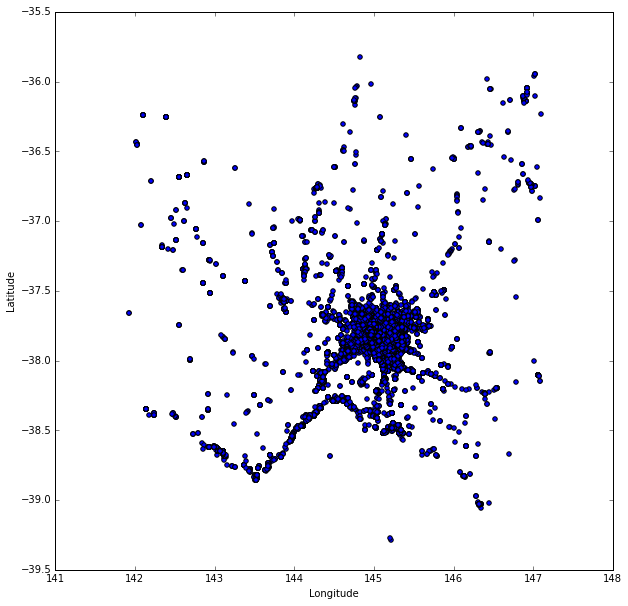

In [10]:
plt.figure(figsize=[10, 10])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['Longitude'], traj['Latitude'])

# 3. Filter Trajectory

After getting an initial list of trajectories, we further filter out improbable trajectories with various criteria.
We use four different criteria as follows:

1. [Timeframe](#3.1.-Filter-by-Timeframe): We only maintain photos/videos taken during a certain period of time (`start_date`, `end_date`)
2. [Duration](#3.2.-Filter-by-Duration): Some suspicious trajectory span over more than 16 hours. We remove trajectories spanning more than certain minutes (`minimum_duration`).
3. [Minimum distance](#3.3.-Filter-by-Minimum-distance): Trajectories consist of photos taken from single location is not meaningful as a trajectory. We remove these trajectories (`minimum_distance`)
4. [Speed](#3.4-Filter-by-Speed): Due to the GPS error, there are some trajectories in which a user moves unbelievably fast speed. We remove these trajectories, but try to recover as much information as possible from some trajectories.

Here's the list of argument we used to generate final trajectories

In [11]:
start_date = '2000-01-01'
end_date = '2015-99-99'
minimum_distance = 0.5   # km
speed_filter = 0    #(0: filter by average speed, 1: filter by point-to-point speed, 2: filter by sophispicated method)
maximum_speed = 100    # km/h
maximum_duration = 3000    # minute

## 3.1. Filter by Timeframe

### 3.1.1. Bar chart of taken photos by year

First, we filter out trajectories taken from certain period of time to remove any future photos caused by some errors and too old photos. 

**(The filtering has been done in `filtering_bigbox.py`)**

Here's the bar chart that plots the number of photos taken by each year.

In [12]:
yeardict = dict()
for i in raw.index:
    dt = raw.ix[i]['Timestamp']
    if dt.year not in yeardict: yeardict[dt.year] = 1
    else: yeardict[dt.year] += 1

<Container object of 15 artists>

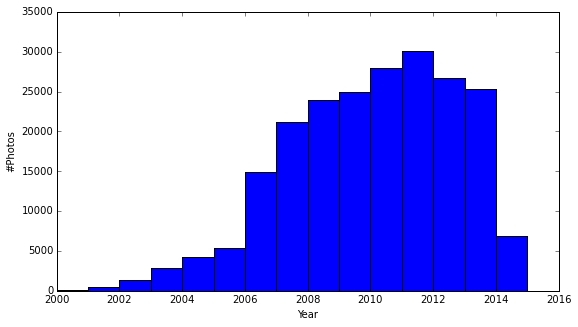

In [13]:
plt.figure(figsize=[9, 5])
plt.xlabel('Year')
plt.ylabel('#Photos')
X = list(sorted(yeardict.keys()))
Y = [yeardict[x] for x in X]
plt.bar(X, Y, width=1)

## 3.2. Filter by Duration

Second, we filter out trajectories which have suspiciously long travel time or the traveling time is zero.

In [14]:
traj_stats1 = traj_stats[traj_stats['Total_Time(min)'] < maximum_duration]
traj1 = traj[traj['Trajectory_ID'].isin(traj_stats1['Trajectory_ID'])]
traj_stats1 = traj_stats1[traj_stats1['Total_Time(min)'] != 0]
traj1 = traj1[traj1['Trajectory_ID'].isin(traj_stats1['Trajectory_ID'])]

### 3.2.1. Histogram of trajectory duration

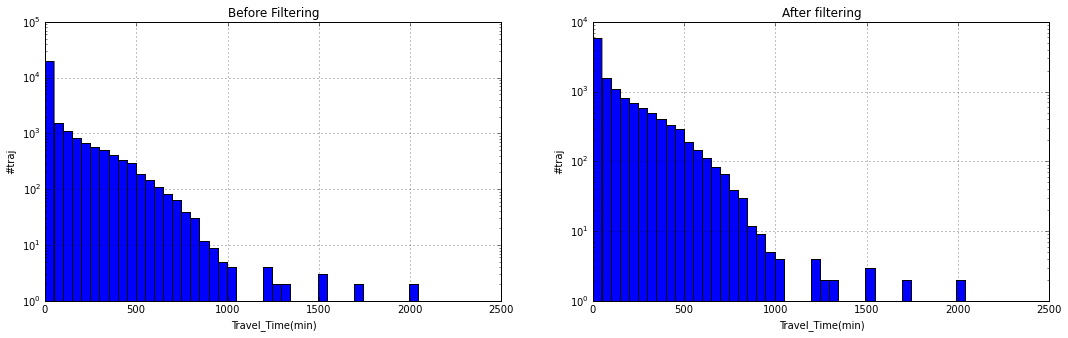

In [15]:
plt.figure(figsize=[18, 5])
plt.subplot(1,2,1)
plt.xlabel('Travel_Time(min)')
plt.ylabel('#traj')
plt.title('Before Filtering')
ax0 = traj_stats['Total_Time(min)'].hist(bins=50)
ax0.set_yscale('log')

plt.subplot(1,2,2)
plt.xlabel('Travel_Time(min)')
plt.ylabel('#traj')
plt.title('After filtering')
ax1 = traj_stats1['Total_Time(min)'].hist(bins=50)
ax1.set_yscale('log')

##  3.3. Filter by Minimum distance

Third, we filter out trajectories taken from a single location.

In [16]:
traj_stats2 = traj_stats1[traj_stats1['Travel_Distance(km)'] > minimum_distance]
traj2 = traj1[traj1['Trajectory_ID'].isin(traj_stats2['Trajectory_ID'])]

#### 3.3.1. Histogram of trajectory length

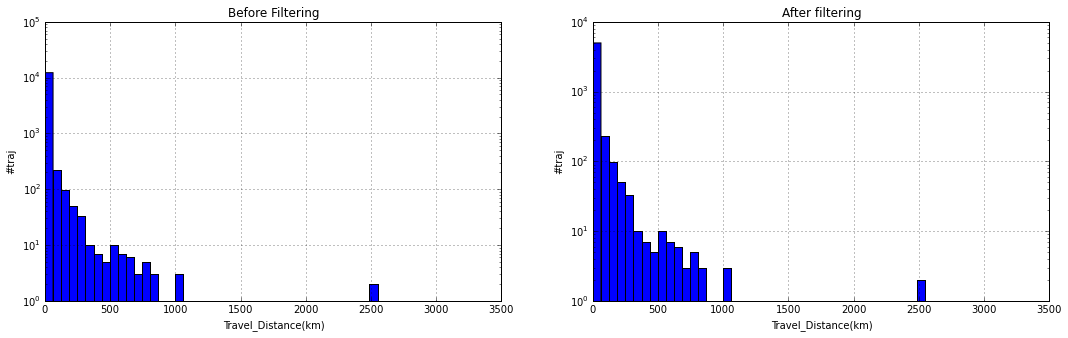

In [17]:
plt.figure(figsize=[18, 5])
plt.subplot(1,2,1)
plt.xlabel('Travel_Distance(km)')
plt.ylabel('#traj')
plt.title('Before Filtering')
ax1 = traj_stats1['Travel_Distance(km)'].hist(bins=50)
ax1.set_yscale('log')

plt.subplot(1,2,2)
plt.xlabel('Travel_Distance(km)')
plt.ylabel('#traj')
plt.title('After filtering')
ax2 = traj_stats2['Travel_Distance(km)'].hist(bins=50)
ax2.set_yscale('log')

## 3.4. Filter by Speed

Some trajectories have suspiciously high speed 
There are three (or more) alternative ways to filter out trajectory which has suspiciously high speed.

In [18]:
traj_stats_new = traj_stats2
traj_new = traj2

### 3.4.1. Drop trajectory by average speed

In [19]:
if speed_filter == 0:
    traj_stats_new = traj_stats_new[traj_stats_new['Average_Speed(km/h)'] < maximum_speed]
    traj_new = traj_new[traj_new['Trajectory_ID'].isin(traj_stats_new['Trajectory_ID'])]

#### 3.4.1.1. Histogram of trajectory speed

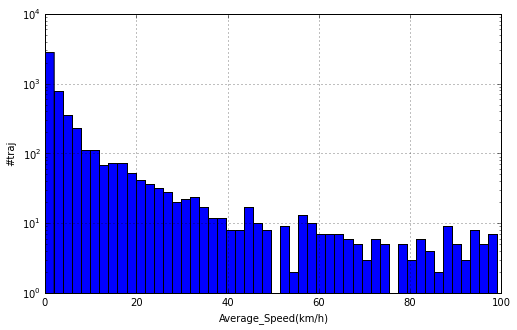

In [20]:
if speed_filter == 0:
    plt.figure(figsize=[18, 5])
    plt.subplot(1,2,1)
    plt.xlabel('Average_Speed(km/h)')
    plt.ylabel('#traj')
    ax = traj_stats_new['Average_Speed(km/h)'].hist(bins=50)
    ax.set_yscale('log')

### 3.4.2. Drop trajectory by point-to-point speed

There are four cases of supersonic trajectory might be happened

1. The first point of trajectory is far away from the rest of the trajectory (GPS calibrating/entering building etc..)
2. The last point of trajectory is far away from the rest of the trajectory
3. One or more middle points of trajectory are far way from the rest of the trajectory (GPS error)
4. Mixture of previous three cases

The first and second cases are easy to recover by cutting the corresponding point. But it seems we could not easily decide which point(s) should be cut for third and fourth cases. We've decided to remove trajectories in case 3 and 4.


Compute point-to-point speed before filtering

In [21]:
# compute point-to-point speed
speeds = []
if speed_filter == 1:   
    for tid in traj_stats_new['Trajectory_ID']:
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] < 2: continue
        for i in range(len(photos.index)-1):
            idx1 = photos.index[i]
            idx2 = photos.index[i+1]
            dist = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                             photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
            seconds = (photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds()
            if seconds == 0: continue
            speed = dist * 60. * 60. / abs(seconds)
            speeds.append(speed)

Histogram of point-to-point speed before filtering

In [22]:
# plot histogram
S = [100, 150, 200, 250, 500, 1000, 1236, 100000]
if speed_filter == 1:
    p2pspeeds = pd.Series(speeds)
    plt.figure(figsize=[18,10])
    for it in range(len(S)):
        plt.subplot(4,2,it+1)
        plt.ylabel('#point-pair')
        plt.title('Speed < ' + str(S[it]) + ' km/h')
        ax = p2pspeeds[p2pspeeds < S[it]].hist(bins=50)
        ax.set_yscale('log')

Drop the first/last point in a trajectories for case1/case2, drop enter trajectories for case3 and case4

In [23]:
if speed_filter == 1:
    # raise an exception if assigning value to a copy (instead of the original data) of DataFrame
    pd.set_option('mode.chained_assignment','raise') 
    traj_stats_new = traj_stats_new.copy()
    traj_new = traj_new.copy()

    indicator_traj = pd.Series(data=np.ones(traj_stats_new.shape[0], dtype=np.bool), index=traj_stats_new.index)
    indicator_photo = pd.Series(data=np.ones(traj_new.shape[0], dtype=np.bool), index=traj_new.index)
    cnt1 = 0
    cnt2 = 0
    cnt34 = 0
    for i in traj_stats_new['Trajectory_ID'].index:
        tid = traj_stats_new.loc[i, 'Trajectory_ID']
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] <= 2:
            if traj_stats_new.loc[i, 'Average_Speed(km/h)'] > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
            continue
        idx1 = photos.index[0]
        idx2 = photos.index[1]
        idx3 = photos.index[-2]
        idx4 = photos.index[-1]
        d12 = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                        photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
        d24 = generate_tables.calc_dist(photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'], \
                                        photos.loc[idx4, 'Longitude'], photos.loc[idx4, 'Latitude'])
        t12 = abs((photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds())
        t24 = abs((photos.loc[idx2, 'Timestamp'] - photos.loc[idx4, 'Timestamp']).total_seconds())
        # check case 1
        if t12 == 0 or (d12 * 60. * 60. / abs(t12)) > maximum_speed:
            if t24 == 0 or (d24 * 60. * 60. / abs(t24)) > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
                continue
            else: # case 1, drop the first photo, update trajectory statistics
                #traj_stats.ix[i]['Start_Time'] = photos.ix[idx2]['Timestamp'] # SettingWithCopyWarning
                indicator_photo.loc[idx1] = False
                traj_stats_new.loc[i, 'Start_Time'] = photos.loc[idx2, 'Timestamp']
                traj_stats_new.loc[i, 'Travel_Distance(km)'] = d24
                traj_stats_new.loc[i, 'Total_Time(min)'] = t24 / 60.
                traj_stats_new.loc[i, 'Average_Speed(km/h)'] = d24 * 60. * 60. / t24
                cnt1 += 1
                continue
        # check case 2
        d34 = generate_tables.calc_dist(photos.loc[idx3, 'Longitude'], photos.loc[idx3, 'Latitude'], \
                                        photos.loc[idx4, 'Longitude'], photos.loc[idx4, 'Latitude'])
        d13 = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                        photos.loc[idx3, 'Longitude'], photos.loc[idx3, 'Latitude'])
        t34 = abs((photos.loc[idx3, 'Timestamp'] - photos.loc[idx4, 'Timestamp']).total_seconds())
        t13 = abs((photos.loc[idx1, 'Timestamp'] - photos.loc[idx3, 'Timestamp']).total_seconds())
        if t34 == 0 or (d34 * 60. * 60. / abs(t34)) > maximum_speed:
            if t13 == 0 or (d13 * 60. * 60. / abs(t13)) > maximum_speed: # drop the trajectory
                indicator_traj.loc[i] = False
                indicator_photo.loc[photos.index] = False
                continue
            else: # case 2, drop the last photo, update trajectory statistics
                #traj_stats.ix[i]['Travel_Distance(km)'] = d13 # SettingWithCopyWarning
                indicator_photo.loc[idx4] = False
                traj_stats_new.loc[i, 'Travel_Distance(km)'] = d13
                traj_stats_new.loc[i, 'Total_Time(min)'] = d13 / 60.
                traj_stats_new.loc[i, 'Average_Speed(km/h)'] = d13 * 60. * 60. / t13
                cnt2 += 1
                continue
            
        # case 3 or 4, drop trajectory
        if traj_stats_new.loc[i, 'Average_Speed(km/h)'] > maximum_speed:
            indicator_traj.loc[i] = False
            indicator_photo.loc[photos.index] = False
            cnt34 += 1
    
    print('Number of trajectories in case 1:', cnt1)
    print('Number of trajectories in case 2:', cnt2)
    print('Number of trajectories in case 3 & 4:', cnt34)

    traj_new = traj_new[indicator_photo]
    traj_stats_new = traj_stats_new[indicator_traj]

Compute point-to-point speed after filtering

In [24]:
# compute point-to-point speed
speeds_new = []
if speed_filter == 1:
    for tid in traj_stats_new['Trajectory_ID']:
        photos = traj_new[traj_new['Trajectory_ID'] == tid]
        if photos.shape[0] < 2: continue
        for i in range(len(photos.index)-1):
            idx1 = photos.index[i]
            idx2 = photos.index[i+1]
            dist = generate_tables.calc_dist(photos.loc[idx1, 'Longitude'], photos.loc[idx1, 'Latitude'], \
                                             photos.loc[idx2, 'Longitude'], photos.loc[idx2, 'Latitude'])
            seconds = (photos.loc[idx1, 'Timestamp'] - photos.loc[idx2, 'Timestamp']).total_seconds()
            if seconds == 0: continue
            speed = dist * 60. * 60. / abs(seconds)
            speeds_new.append(speed)

### 3.4.3 Drop trajectory by sophisticated method


In [25]:
#if speed_filter == 2:

# 4. Filtered Trajectory

## 4.1. Basic Stats

More detail analysis will be included in `filckr_analysis.ipynb` and slides. Here we show simple stats from the final result.

In [26]:
traj_stats_new.describe()

,Trajectory_ID,#Photo,Travel_Distance(km),Total_Time(min),Average_Speed(km/h)
count,5096.000000,5096.000000,5096.000000,5096.000000,5096.000000
mean,13437.630298,12.245683,17.491332,237.949719,6.579735
std,7476.100647,22.019228,50.281598,212.770742,13.775661
min,7.000000,2.000000,0.500571,0.400000,0.043375
25%,6954.750000,3.000000,1.337506,71.425000,0.662980
50%,13494.000000,5.000000,3.757678,184.816667,1.708018
75%,19957.000000,12.000000,11.553428,353.175000,5.191270
max,26462.000000,379.000000,1007.089505,2488.683333,99.056659


**Save final trajectories to the data folder**

In [27]:
file1 = os.path.join(data_dir + table1)
file2 = os.path.join(data_dir + table2)
traj_new.to_csv(file1, index=False)
traj_stats_new.to_csv(file2, index=False)